# Algorithme d'estimation de phase
Francis Blais (2151696) et Vincent Girouard (2152383)

12 novembre 2023
## Objectif de l'algorithme
L'algorithme d'estimation de phase est un algorithme assez particulier dans le sens que le problème qu'il essaie de résoudre est purement quantique***. On considère un opérateur unitaire inconnu $U$ et un état d'entrée $\ket{\psi}$ de $n$ qubits. Il nous est assuré que $\ket{\psi}$ est un état propre de $U$ tel que

$$ U\ket{\psi} = \lambda\ket{\psi}  $$

où $\lambda$ est la valeur propre associée à l'état $\ket{\psi}$. Comme $U$ est unitaire, $|\lambda|^2=1$ ce qui permet de simplifier le problème en décrivant complètement la valeur propre par une phase $\theta\in[0,1[$ comme suit : $\lambda = e^{i2\pi\theta}$. Comme son nom l'indique, l'algorithme d'estimation de phase a pour objectif d'approximer selon une précision voulue la valeur de $\theta$. On parle ici d'approximation, car la précision à laquelle il sera possible de connaitre $\theta$ dépendra du nombre de quibit de référence choisi. Cet algorithme diffère un peu d'autres algorithmes quantiques dans le sens qu'ici, l'entrée comprend un état quantique $\ket{\psi}$. De ce fait, cet algorithme est souvent utilisé en pair avec d'autres algorithmes plus complexes. C'est noramment une partie très importante de l'algorithme de Shor permettant de factoriser des entiers. 

## Description de l'algorithme

## Principe de fonctionnement

## Implémentation

Dans cette section, l'algorithme d'estimaion de phase sera implémenté à un système dont l'état d'entré est de $N$ qubits. Pour ce faire, les librairies *qutip* et *qutip-qip* sont utilisées afin de simuler un un tel circuit quantique. Dans la suite, le code utilisé est présenté et des exemples sont réalisés afin de montrer le fonctionnement de l'algorithme d'estimation de phase.

1) Importation des librairies

In [2]:
# Importation des librairies
import numpy as np
from qutip import tensor, basis
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate, Measurement
from qutip_qip.algorithms import qft
import matplotlib.pyplot as plt
import random

2) Définition des fonctions utiles

In [3]:
def compute_phase(bit_sequence):
    """
    Fonction qui prend en entrée un vecteur de bit classique et qui le convertie en base 10 entre 0 et 1
    """
    num = 0
    for bit_index in range(len(bit_sequence)):
        num += bit_sequence[bit_index]*2**(-bit_index-1)
    return num

3) Modélisation du circuit quantique

Dans ce circuit, $N+1$ qubits entrent dans le système. Le premier est simplement un état propre de l'opérateur unitaire dont on doit estimer la valeur propre (phase). Pour des fins de simplicité, l'opérateur unitaire utilisé est un opérateur de phase contrôlé *CPHASE*. Cet opérateur prend comme argument une phase $\theta$ entre $0$ et $2\pi$ et est tel que CP $\ket{0} = \ket{0}$ et CP $\ket{1} = \theta\ket{1}$ si le qubit de contrôle est $\ket{1}$. Cet opérateur est donc parfait pour cette démonstration car il permet de définir simplement la phase à estimer. Cependant, l'algorithme fonctionnerait avec tout autre opérateur unitaire. Les $N$ autres qubits sont sont les bits qui seront utilisés pour l'estimation de la phase et sont initialisés à $\ket{0}$. L'état d'entré est donc: $\ket{\psi} = \ket{1} \otimes \ket{0} \otimes \ket{0} ... \otimes \ket{0}$. En premier lieux, les qubits $\ket{0}$ passent par une porte $H$ afin d'être dans l'état $\ket{+}$. Ensuite, les états $\ket{+}$ sont utilisés comme qubits de contrôle un à la suite pour les opérateurs de phase. Il y a donc $N$ opérateurs de phase (un pour chaque qubit). Ils sont tels que $U_n = CP(\theta)^{2^n}$, ce qui est équivalent à $U_n = CP(\theta\times 2^{n})$ pour $n \in \{0,1,...,N-1\}$. Ainsi, à chaque porte, la phase de $\ket{1}$ est doublée. Enfin, la dernière porte efectue une transformée de Fourier quantique inverse (*QFT*$^\dagger$). Des mesures sont réalisées sur chaque qubit de contôle de façon probabiliste et la séquence obtenue est convertie en base 10.

In [4]:
def estimation_phase(N, phase):
    # Initialisation du circuit
    input_label = ['1' if i == 0 else '0' for i in range(N+1)]    
    circuit = QubitCircuit(N=N+1, input_states=input_label)           

    # Ajout des portes de Hadamard pour chaque qubit
    H_gates = [Gate("SNOT", targets=i+1, arg_label='H') for i in range(N)]     
    circuit.add_gates(H_gates)

    # Ajout de l'opérateur de phase
    cphase_gates = [Gate("CPHASE", targets=0, controls=N-i, arg_value=2*np.pi*phase*2**i, arg_label=f'P^{i+1}') for i in range(N)]
    circuit.add_gates(cphase_gates)

    # Ajout de l'opérateur de QFT inverse
    qft_matrix = qft(N).dag()
    circuit.user_gates = {"INV_QFT": qft_matrix}
    circuit.add_gate("INV_QFT", targets=[i+1 for i in range(N)], arg_label="QFT^{\dag}")

    # État initial du système et calcul de l'état de sortie
    initial_state = tensor([basis(2,1) if i == 0 else basis(2,0) for i in range(N+1)])
    result = circuit.run(state=initial_state)

    # Mesures des qubits à la sortie
    measure_dict = {"m%d" % (i+1) : i for i in range(N)}
    for index, keys in enumerate(measure_dict):
        measure_dict[keys] = Measurement(name=keys, targets=(N-index)).measurement_comp_basis(result)[1]

    # Lecture de la phase
    bit_output_sequence = []
    for values in measure_dict.values():
        bit_output_sequence.append(random.choices([0, 1], weights=values, k=1)[0])
    phase_estimation = compute_phase(bit_output_sequence[::-1])
    erreur = phase - phase_estimation
    return phase_estimation, erreur, circuit, measure_dict

Par exemple, essayons d'estimer une phase de $\theta = 0.7546$ avec un système de 8 qubits. Le code qui suit effectue cette simulation et retourne la phase obtenue ainsi que l'erreur associée. De plus, le circuit équivalent est présenté sous forme de shéma.

La phase estimée est de 0.75390625, ce qui donne une erreur de 0.0006937500000000485


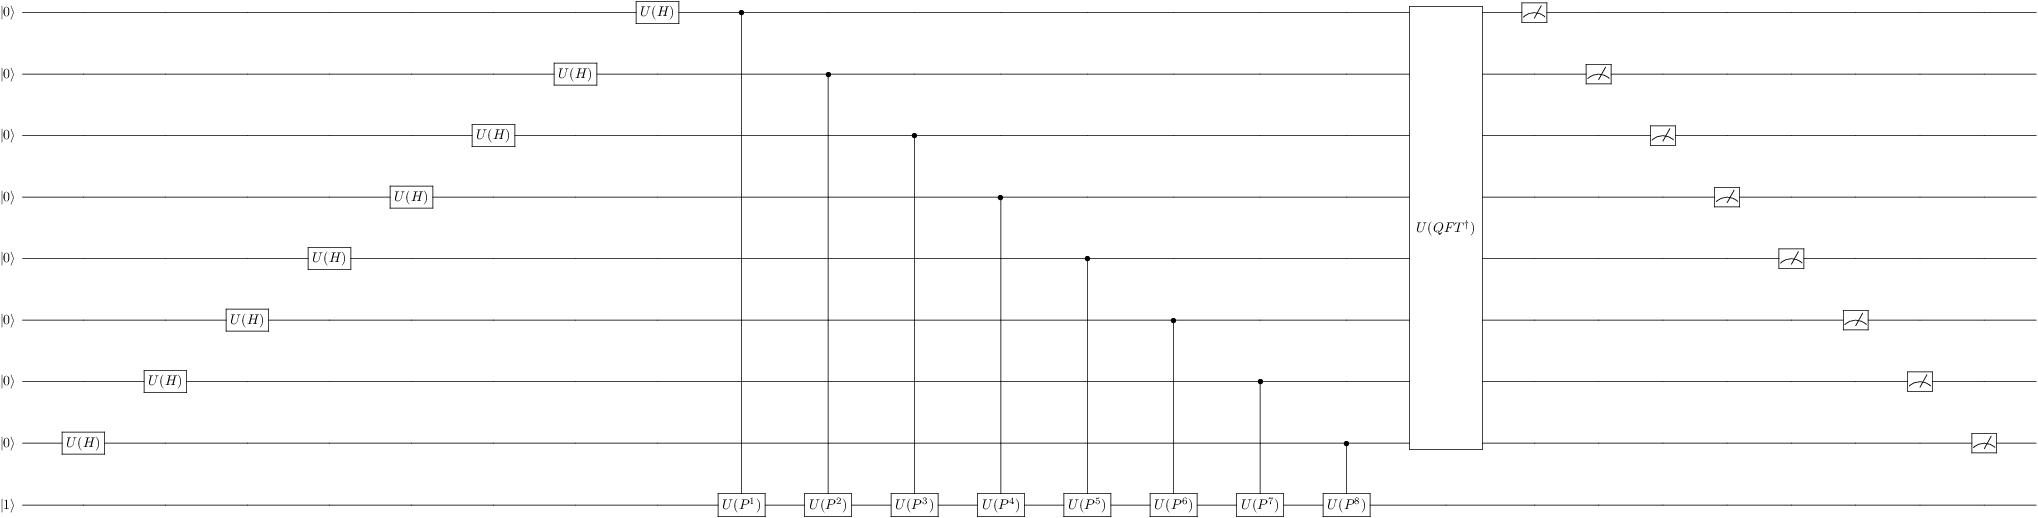

In [98]:
N = 8
phase = 0.7546
phase_estimation, erreur, circuit, measure_dict = estimation_phase(N=N, phase=phase)
print(f"La phase estimée est de {phase_estimation}, ce qui donne une erreur de {erreur}")
for index, key in enumerate(measure_dict):
    circuit.add_measurement(measure_dict[key], targets=[N-index])
circuit.png

On peut également essayer d'autres combinaisons de phase et de nombre de bit. Par exemple, voici la phase estimée pour une phase réelle de $\theta = 0.66666$ en fonction du nombre de qubits du système. On voit donc que le fait d'augmenter le nombre de qubits augmente la qualité de l'approximation.

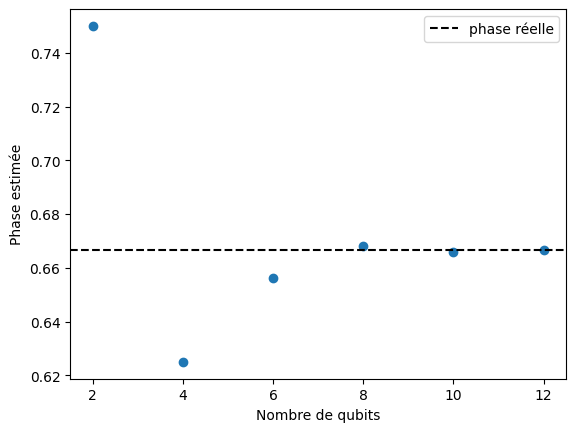

In [11]:
N = np.arange(2,14,2)
phase = 0.66666
phase_est = []
for n in list(N):
    phase_est.append(estimation_phase(N=n, phase=phase)[0])
plt.scatter(N, phase_est)
plt.axhline(y=phase, linestyle = '--', color='black', label='phase réelle')
plt.xlabel('Nombre de qubits')
plt.ylabel('Phase estimée')
plt.legend()

### Remarque
Le résultat de la mesure est probabiliste. L'estimation obtenue est donc aléatoire. Voici un histograme de la phase estimée pour 250 calculs à 8 qubit pour une phase $\theta = 0.3$. On voit que le résultats possède quelques fluctuations, mais que le résultat obtenu est assez stable autour de la vraie valeur.

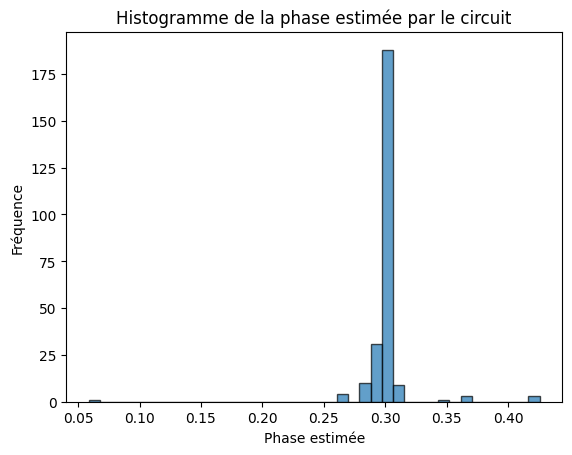

In [111]:
N = 8
phase = 0.30
sample = [estimation_phase(N=N, phase=phase)[0] for i in range(250)]

plt.hist(sample, bins=40, edgecolor='black', alpha=0.7)
plt.title('Histogramme de la phase estimée par le circuit')
plt.xlabel('Phase estimée')
plt.ylabel('Fréquence')
plt.show()

In [115]:
# Quelques statistiques sur les résultats
print(f"Moyenne = {np.mean(sample)}")
print(f"Médianne = {np.median(sample)}")
print(f"Écart-type = {np.std(sample)}")
print(f"Minimum = {np.min(sample)}")
print(f"Maximum = {np.max(sample)}")

Moyenne = 0.30096875
Médianne = 0.30078125
Écart-type = 0.02252578817294747
Minimum = 0.05859375
Maximum = 0.42578125
